In [281]:
import pandas as pd
import datetime
import numpy as np
from scipy import stats as st
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
from scipy.stats import shapiro
from scipy.stats import levene
import pingouin as pg
import scipy.stats as ss
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
from operator import attrgetter
import matplotlib.colors as mcolors
from datetime import datetime
from scipy.stats import chi2_contingency
import requests 
from urllib.parse import urlencode
import scipy.stats as stats
%matplotlib inline
from tqdm.auto import tqdm
import seaborn as sns

Распространённая и самая известная на рынке схема мошенничества: мошенник берёт данные ИНН из открытых источников, регистрирует на него компанию на площадке маркетплейса. Далее выставляет ходовой товар на продажу, например iPhone 14, на 50% дешевле рынка. Когда покупатель оформляет заказ на маркетплейсе, продавец пишет покупателю, что у него есть другой сайт, где можно купить товар ещё дешевле. Покупатель соглашается и оплачивает заказ по ссылке продавца в обход площадки. После этого продавец пропадает. Покупатель остается без товара. Такие продавцы очень сильно портят репутацию маркетплейса, и необходимо их выявлять как можно быстрее, лучше всего в процессе регистрации.

Для этого ML-команда предложила к использованию модель по автоопределению продавцов-мошенников, которую нам предлагается внедрить в процесс регистрации продавца.

Мы хотим ввести новый функционал, но как data-driven компания не можем это сделать без тестирования и проверки качества новой функциональности через A/B-тест.

1 Cчитывание датасета

In [282]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 

public_key = 'https://disk.yandex.ru/d/gdXR2lcq7vVutg'
final_url = base_url + urlencode(dict(public_key=public_key)) 
response = requests.get(final_url) 
download_url = response.json()['href']
warnings.simplefilter(action='ignore', category=Warning)

In [283]:
Antifrauddf = pd.read_csv(download_url, sep=';')

In [284]:
Antifrauddf

,registration_date,activation_date,merchant_id,type,ind_frod
0,16.12.2023,24.12.2023,1,IE,0.0
1,05.09.2023,08.09.2023,2,IE,0.0
2,16.04.2023,22.04.2023,3,IE,0.0
3,23.12.2023,24.12.2023,4,IE,0.0
4,28.01.2023,NaN,5,IE,0.0
...,...,...,...,...,...
34995,20.10.2023,31.10.2022,34996,LLC,0.0
34996,20.04.2023,22.04.2023,34997,LLC,0.0
34997,24.08.2023,04.09.2023,34998,LLC,0.0
34998,08.06.2023,18.06.2023,34999,LLC,0.0


In [285]:
Antifrauddf.isna().sum()

registration_date        0
activation_date      14700
merchant_id              0
type                     0
ind_frod               700
dtype: int64

In [286]:
Antifrauddf.merchant_id.nunique()==Antifrauddf.shape[0] # Нет ли повторных регистраций одного и того же пользователя

True

In [287]:
Antifrauddf.drop_duplicates() #Дубликатов нет

,registration_date,activation_date,merchant_id,type,ind_frod
0,16.12.2023,24.12.2023,1,IE,0.0
1,05.09.2023,08.09.2023,2,IE,0.0
2,16.04.2023,22.04.2023,3,IE,0.0
3,23.12.2023,24.12.2023,4,IE,0.0
4,28.01.2023,NaN,5,IE,0.0
...,...,...,...,...,...
34995,20.10.2023,31.10.2022,34996,LLC,0.0
34996,20.04.2023,22.04.2023,34997,LLC,0.0
34997,24.08.2023,04.09.2023,34998,LLC,0.0
34998,08.06.2023,18.06.2023,34999,LLC,0.0


In [288]:
Antifrauddf.dtypes

registration_date     object
activation_date       object
merchant_id            int64
type                  object
ind_frod             float64
dtype: object

переведем данные с датами во временной формат

In [289]:
Antifrauddf['registration_date'] = pd.to_datetime(Antifrauddf['registration_date']) 
Antifrauddf['activation_date'] = pd.to_datetime(Antifrauddf['activation_date'])

In [290]:
Antifrauddf.dtypes #Теперь у дат временной формат

registration_date    datetime64[ns]
activation_date      datetime64[ns]
merchant_id                   int64
type                         object
ind_frod                    float64
dtype: object

In [291]:
Antifrauddf.head(10)

,registration_date,activation_date,merchant_id,type,ind_frod
0,2023-12-16,2023-12-24,1,IE,0.0
1,2023-05-09,2023-08-09,2,IE,0.0
2,2023-04-16,2023-04-22,3,IE,0.0
3,2023-12-23,2023-12-24,4,IE,0.0
4,2023-01-28,NaT,5,IE,0.0
5,2023-05-07,NaT,6,IE,0.0
6,2023-06-25,NaT,7,IE,0.0
7,2023-10-27,2023-10-29,8,IE,0.0
8,2023-06-18,2023-06-24,9,IE,0.0
9,2023-12-21,NaT,10,IE,0.0


Уберем значения, где дата активации позже даты регистрации, что невозможно технически

In [292]:
Antifraud_filtered = Antifrauddf.drop(Antifrauddf[Antifrauddf['activation_date'] < Antifrauddf['registration_date']].index)

In [293]:
Antifraud_filtered

,registration_date,activation_date,merchant_id,type,ind_frod
0,2023-12-16,2023-12-24,1,IE,0.0
1,2023-05-09,2023-08-09,2,IE,0.0
2,2023-04-16,2023-04-22,3,IE,0.0
3,2023-12-23,2023-12-24,4,IE,0.0
4,2023-01-28,NaT,5,IE,0.0
...,...,...,...,...,...
34991,2023-12-24,NaT,34992,LLC,1.0
34992,2023-12-16,2023-12-23,34993,LLC,0.0
34994,2023-06-14,NaT,34995,LLC,0.0
34996,2023-04-20,2023-04-22,34997,LLC,0.0


#Также проверим, когда начались и закончились наши наблюдения за поведением продавцов

In [294]:
print ("Наблюдения за регистрацией начались", Antifraud_filtered.registration_date.min()) 
print ("Наблюдения за регистрацией закончились", Antifraud_filtered.registration_date.max()) 
print("Наблюдения за активацией начались", Antifraud_filtered.activation_date.min())
print("Наблюдения за активацией закончились", Antifraud_filtered.activation_date.max())

Наблюдения за регистрацией начались 1970-01-01 00:00:00
Наблюдения за регистрацией закончились 2023-12-31 00:00:00
Наблюдения за активацией начались 2023-01-04 00:00:00
Наблюдения за активацией закончились 2024-11-01 00:00:00


Последняя запись в датасете о регистрациях  не вызывает подозрений, но начались наблюдения довольно подозрительно рано, настолько что не существовало технологий, фиксирующих это. Также магическим образом часть пользователей получило активацию в будущем, под конец 2024 года

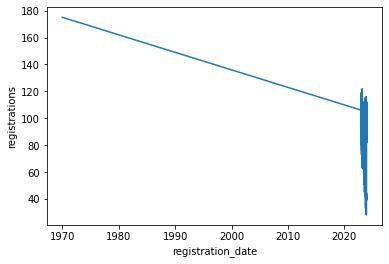

In [295]:
registration_counts = Antifraud_filtered.groupby('registration_date')\
    .agg({'merchant_id': 'count'})\
    .rename(columns={'merchant_id': 'registrations'})\
    .sort_values(by='registration_date', ascending=True)\
    .reset_index()
registration_counts
sns.lineplot(data=registration_counts, x="registration_date", y="registrations")

    Распределение данных до периода после 2020 года говорит о искуственной природе и имеем право допустить, что это является аномалией,поэтому принято решение откинуть все наблюдения после 2020

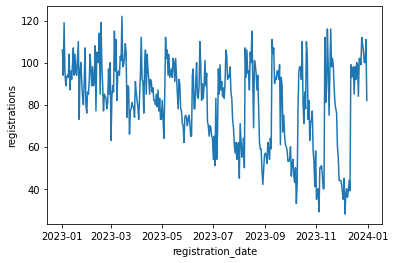

In [296]:
registration_counts=registration_counts.query('registration_date>"2019-01-01"') 
sns.lineplot(data=registration_counts, x="registration_date", y="registrations")

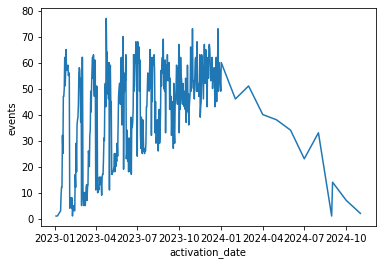

In [297]:
# Посмотрим, что с датами активации, там тоже были проблемы и очевидные аномалии
registration_counts = Antifraud_filtered.groupby('activation_date')\
    .agg({'merchant_id': 'count'})\
    .rename(columns={'merchant_id': 'events'})\
    .sort_values(by='activation_date', ascending=True)\
    .reset_index()
registration_counts
sns.lineplot(data=registration_counts, x="activation_date", y="events")

Даты после января 2024 лучше выкинуть, но заложим с запасом 1 месяц, поскольку регистрация может длиться больше
registration_counts=registration_counts.query('activation_date>"2024-02-01"')

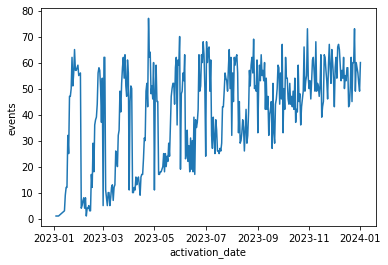

In [298]:
registration_counts=registration_counts.query('activation_date<"2024-02-01"')
sns.lineplot(data=registration_counts, x="activation_date", y="events")

Теперь мы видим, что диапазон примерно  в период с начала 2023 по начало 2024

In [299]:
Antifraud_filtered=Antifraud_filtered.query('registration_date>"2023-01-01"' )
Antifraud_filtered = Antifrauddf.drop(Antifrauddf[Antifrauddf['activation_date'] < "2024-02-01"].index) # Убираем значения после февраля 2024, оставляем Null
Antifraud_filtered # Убираем значения после февраля 2024 и до , оставляем Null
Antifraud_filtered

,registration_date,activation_date,merchant_id,type,ind_frod
4,2023-01-28,NaT,5,IE,0.0
5,2023-05-07,NaT,6,IE,0.0
6,2023-06-25,NaT,7,IE,0.0
9,2023-12-21,NaT,10,IE,0.0
10,2023-06-13,NaT,11,IE,0.0
...,...,...,...,...,...
34985,2023-11-21,NaT,34986,LLC,0.0
34986,2023-10-05,NaT,34987,LLC,0.0
34987,2023-04-04,NaT,34988,LLC,0.0
34991,2023-12-24,NaT,34992,LLC,1.0


### Основные аномалии мы убрали Теперь можно приступить к дизайну AB теста, выбором контрольной и тестовой группы, выбором метрик 

Исходя из структуры данных, мне представилось интересным проанализировать метрику времени между регистрацией до активацией, также отдельно стоит рассмотреть случай, в котором активация еще не состоялась, и какая доля мошенников будет в этой группе. Сравним эффективность определения мошенников ручным способом, разделим на группы и проведем стат. тест

Метрика времени между регистрацией и активацией была выбрана также потому, что мошенник определялся вручную, то есть можно не исключать человеческий фактор, где могли за короткое время проверить и активировать пользователя, оказавшегося мошенником.

In [300]:
Antifraud_filtered = Antifraud_filtered.dropna(subset=['ind_frod']) 
#Уберем Nan значения для стооблца Ind_frod, поскольку в нашем случае эти данные нельзя использовать как полезные

In [301]:
Antifraud_filtered['time_to_activation'] = (Antifraud_filtered['activation_date'] - Antifraud_filtered['registration_date']).dt.days
Antifraud_filtered # расчет метрики

,registration_date,activation_date,merchant_id,type,ind_frod,time_to_activation
4,2023-01-28,NaT,5,IE,0.0,NaN
5,2023-05-07,NaT,6,IE,0.0,NaN
6,2023-06-25,NaT,7,IE,0.0,NaN
9,2023-12-21,NaT,10,IE,0.0,NaN
10,2023-06-13,NaT,11,IE,0.0,NaN
...,...,...,...,...,...,...
34985,2023-11-21,NaT,34986,LLC,0.0,NaN
34986,2023-10-05,NaT,34987,LLC,0.0,NaN
34987,2023-04-04,NaT,34988,LLC,0.0,NaN
34991,2023-12-24,NaT,34992,LLC,1.0,NaN


In [302]:
Antifraud_split1 = Antifraud_filtered[Antifraud_filtered['activation_date'].notna()]
Antifraud_split1

,registration_date,activation_date,merchant_id,type,ind_frod,time_to_activation
28,2023-12-29,2024-06-01,29,IE,1.0,155.0
120,2023-12-23,2024-02-01,121,IE,0.0,40.0
443,2023-12-27,2024-03-01,444,IE,0.0,65.0
951,2023-12-29,2024-05-01,952,IE,0.0,124.0
1233,2023-12-29,2024-04-01,1234,IE,0.0,94.0
...,...,...,...,...,...,...
34679,2023-12-30,2024-03-01,34680,LLC,0.0,62.0
34700,2023-12-31,2024-05-01,34701,LLC,0.0,122.0
34771,2023-12-29,2024-03-01,34772,LLC,0.0,63.0
34890,2023-08-23,2024-08-30,34891,LLC,0.0,373.0


In [303]:
threshold = Antifraud_split1 ['time_to_activation'].median() #Поделим  значение на медианное

Разделим покупателей на контрольную и тестовую группу, где 
Контрольная группа: Группа с "быстрой" активацией.
Тестовая группа: Группа с "медленной" активацией.

In [304]:
Antifraud_split1['duration'] = np.where(Antifraud_split1['time_to_activation'] <= threshold, 'fast_activation', 'slow_activation')  

In [305]:

Antifraud_split1

,registration_date,activation_date,merchant_id,type,ind_frod,time_to_activation,duration
28,2023-12-29,2024-06-01,29,IE,1.0,155.0,slow_activation
120,2023-12-23,2024-02-01,121,IE,0.0,40.0,fast_activation
443,2023-12-27,2024-03-01,444,IE,0.0,65.0,fast_activation
951,2023-12-29,2024-05-01,952,IE,0.0,124.0,slow_activation
1233,2023-12-29,2024-04-01,1234,IE,0.0,94.0,fast_activation
...,...,...,...,...,...,...,...
34679,2023-12-30,2024-03-01,34680,LLC,0.0,62.0,fast_activation
34700,2023-12-31,2024-05-01,34701,LLC,0.0,122.0,fast_activation
34771,2023-12-29,2024-03-01,34772,LLC,0.0,63.0,fast_activation
34890,2023-08-23,2024-08-30,34891,LLC,0.0,373.0,slow_activation


In [ ]:
https://jupyter.lab.karpov.courses/user/a-drugov/notebooks/Untitled%20Folder/AB_context_Samokat.ipynb#

In [310]:
contingency_table = pd.crosstab(Antifraud_split1['duration'], Antifraud_split1['ind_frod'])
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
print(f"\nХи-квадрат статистика: {chi2}")
print(f"P-значение: {p}")


Хи-квадрат статистика: 2.5737814091863997
P-значение: 0.10864774066896184


Среднее время до активации: 195.8 дней


Среднее время до активации: 123.0 дней
